In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from scipy.optimize import curve_fit

# Demonstrating chaos

This notebook demonstrates chaos by computing the divergence between two trajectories with nearby initial conditions. The exponential growth of the distance between trajectories in state space over time indicates a sensitive dependence on initial conditions.

It is sufficient to show this exponential growth in a subset of state space. We use the set of all bed elevations $\eta$ in the model as our subset.

## Prerequisites:

We need  base \(eta\_base\) and perturbed \(eta\_perturbed\) trajectories from chaos\_runs.m in the directory of this notebook. chaos\_runs.m needs the chaotic_base workspace for setting parameters for a chaotic delta.


In [2]:
eta_base = scipy.io.loadmat('eta_base.mat')['eta_save']
eta_base.shape

(7, 4000)

In [3]:
eta_comp = scipy.io.loadmat('eta_perturbed.mat')['eta_save']
eta_comp.shape

(7, 4000)

Finding $|d|$ time series


In [4]:
d = []
for t in range(eta_comp.shape[1]):
    d_j = 0
    for j in range(6):
        d_j += np.abs(eta_comp[j+1][t] - eta_base[j+1][t])
    d.append(d_j)

d = np.array(d)

In [5]:
times = scipy.io.loadmat('eta_base.mat')['t_save'][0]
times.shape

(4000,)

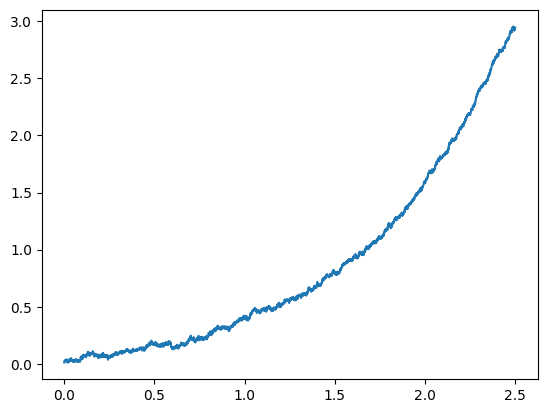

In [6]:
plt.plot(times, d)

## Curve Fitting



In [7]:
def f(t,k, d_0):
    return d_0*np.exp(k*t)

In [8]:
lower_bounds = np.linspace(0, 1000, 10)
upper_bounds = np.linspace(3000,4000,10)

best_lower_bound = 0
best_upper_bound= 4000
best_bounds_r_squared = 0

for lower_bound in lower_bounds:
    for upper_bound in upper_bounds:
        
        lower_bound = int(lower_bound)
        upper_bound = int(upper_bound)
        
        if upper_bound > lower_bound:
            d_truncated = np.copy(d)[lower_bound:upper_bound]
            times_truncated = np.copy(times)[lower_bound:upper_bound]
            
            popt, pcov = curve_fit(lambda t, b: d_truncated[0] * np.exp(b * t),  times_truncated, d_truncated)

            residuals = np.sum((d_truncated - f(times_truncated, popt[0], d_truncated[0]))**2)

            sum_squares = np.sum((d_truncated - np.mean(d_truncated))**2)

            r_squared = 1 - (residuals / sum_squares)

            if 1-r_squared < 1-best_bounds_r_squared:
                best_bounds_r_squared = r_squared
                best_lower_bound = lower_bound
                best_upper_bound = upper_bound
                
                
        
d = d[best_lower_bound : best_upper_bound]
times = times[best_lower_bound : best_upper_bound]

In [9]:
popt, pcov = curve_fit(lambda t, b: d[0] * np.exp(b * t), times, d)

In [10]:
residuals = np.sum((d- f(times,popt[0], d[0]))**2)

sum_squares = np.sum((d-np.mean(d))**2)

r_squared = 1 - (residuals / sum_squares)

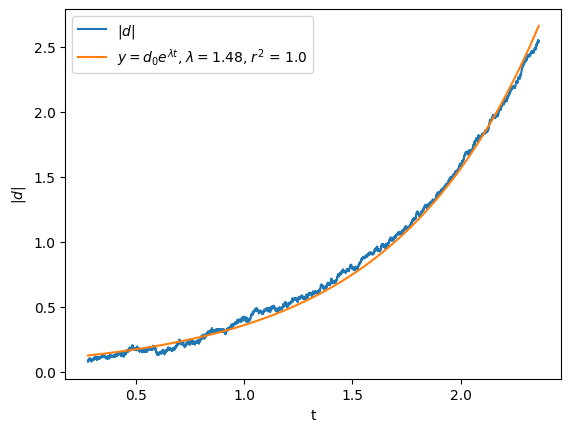

In [15]:
plt.figure()
plt.plot(times, d)
plt.plot(times, f(times, popt[0], d[0]))
plt.xlabel('t')
plt.ylabel('$|d|$')
plt.legend(['$|d|$', '$y = d_0 e^{\lambda t}$, $\lambda = $' + str(np.round(popt[0], 2)) + ', $r^2$ = ' + str(np.round(r_squared,2))])